# TF 2.2 блокнот
[По сути, это перевод стартового блокнота от команды TensorFlow](https://www.kaggle.com/philculliton/a-simple-petals-tf-2-2-notebook)

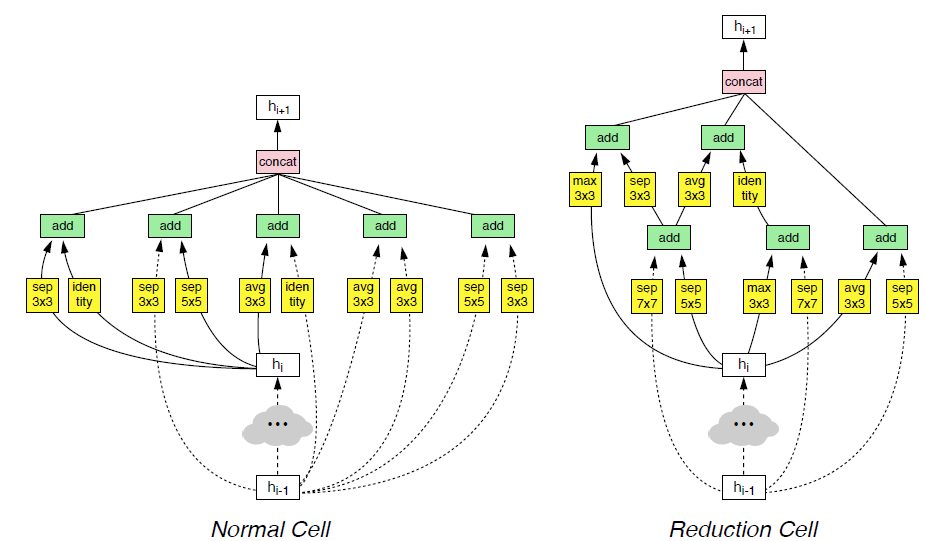
Архитектура NASNet состоит из слоёв двух типов: нормальный слой (слева) и слой сокращения (справа). Эти два слоя спроектированы генератором AutoML
Бенчмарки показали, что автоматически сгенерированный ИИ превосходит по результатам классификации и определения объектов все остальные системы машинного зрения, созданные и обученные экспертами-людьми.
Исследователи подчёркивают, что NASNet можно масштабировать и, следовательно, приспособить для работы на системах со слабыми вычислительными ресурсами без особой потери точности. Нейросеть способна работать даже на мобильном телефоне со слабым CPU с ограниченным ресурсом памяти. Авторы говорят, что миниатюрная версия NASNet демонстрирует точность 74%, что на 3,1 процентных пункта лучше, чем самые качественные известные нейросети для мобильных платформ.

In [ ]:
!pip install -q efficientnet

In [ ]:
#предварительно обученные модели
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.nasnet import NASNetLarge
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2, EfficientNetB0, EfficientNetB1

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, GaussianDropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
#  библиотека для работы с наборами данных на Kaggle
from kaggle_datasets import KaggleDatasets
import re
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline 
print("Tensorflow version " + tf.__version__)

# Определяем, какой ускоритель можем использовать

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
# Обнаружение оборудования, возврат соответствующей стратегии распространения: TPU, GPU, CPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Обнаружение TPU. Параметры среды не требуются, если задана переменная среды TPU_NAME. На Kaggle это всегда так.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # стратегия распространения по умолчанию в Tensorflow. Работает на CPU и одном GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

# Get my data path

In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path("tpu-getting-started") #получаем путь к наборам данных
MORE_IMAGES_GCS_DS_PATH = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')

# Set some parameters

In [ ]:
IMAGE_SIZE = [331, 331] # при таком размере графическому процессору не хватит памяти. Используйте TPU
EPOCHS = 30
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
MOREIMAGES_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

IMAGENET_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/imagenet' + MOREIMAGES_PATH + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/inaturalist' + MOREIMAGES_PATH + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/openimage' + MOREIMAGES_PATH + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/oxford_102' + MOREIMAGES_PATH + '/*.tfrec')

TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES + IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES
SEED = 2020

# Загружаем данные

Эти данные загружаются из Kaggle и автоматически сегментируются для максимального распараллеливания.

In [ ]:
def decode_image(image_data):
    """Декодирует изображение в vyjujvthye. vfnhbwe (тензор)
    Нормализует данные и преобразовывает изображения к указанному размеру"""
    image = tf.image.decode_jpeg(image_data, channels=3) # Декодирование изображения в формате JPEG в тензор uint8.
    image = tf.cast(image, tf.float32) / 255.0  # преобразовать изображение в плавающее в диапазоне [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # явный размер, необходимый для TPU
#     image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string означает байтовую строку
        "class": tf.io.FixedLenFeature([], tf.int64),  # [] означает отдельный элемент
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT) # парсим отдельный пример в указанном формате
    image = decode_image(example['image']) # преобразуем изображение к нужному нам формату
    label = tf.cast(example['class'], tf.int32)
    return image, label # возвращает набор данных пар (изображение, метка)

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string означает байтовую строку
        "id": tf.io.FixedLenFeature([], tf.string),  # [] означает отдельный элемент
        # класс отсутствует, задача этого конкурса - предсказать классы цветов для тестового набора данных
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image']) # преобразуем изображение к нужному нам формату
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    """Читает из TFRecords. Для оптимальной производительности одновременное чтение из нескольких
    файлов без учета порядка данных. Порядок не имеет значения, поскольку мы все равно будем перетасовывать данные"""

    ignore_order = tf.data.Options() # Представляет параметры для tf.data.Dataset.
    if not ordered:
        ignore_order.experimental_deterministic = False # отключить порядок, увеличить скорость

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # автоматически чередует чтение из нескольких файлов
    dataset = dataset.with_options(ignore_order) # использует данные сразу после их поступления, а не в исходном порядке
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # возвращает набор данных пар (изображение, метка), если метка = Истина, или пар (изображение, идентификатор), если метка = Ложь
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    flag = random.randint(1,3)
    coef_1 = random.randint(70, 90) * 0.01
    coef_2 = random.randint(70, 90) * 0.01
    if flag == 1:
        image = tf.image.random_flip_left_right(image, seed=SEED)
    elif flag == 2:
        image = tf.image.random_flip_up_down(image, seed=SEED)
    else:
        image = tf.image.random_crop(image, [int(IMAGE_SIZE[0]*coef_1), int(IMAGE_SIZE[0]*coef_2), 3],seed=SEED)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # набор обучающих данных должен повторяться в течение нескольких эпох
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #готовим следующий набор, пока предыдущий обучается
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() # кешируем набор
    dataset = dataset.prefetch(AUTO) #готовим следующий набор, пока предыдущий обучается
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #готовим следующий набор, пока предыдущий обучается
    return dataset
                               
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# training_dataset = get_training_dataset()
# validation_dataset = get_validation_dataset()

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# Построить модель на TPU (или GPU, или CPU...) с Tensorflow 2.1!

In [ ]:
# функция управляющая изменениями шага обучения в процессе тренировки нейронной сети
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync#0.0001
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# построим график изменения шага обучение в зависимости от эпох
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
def get_model(use_model):
    # noisy-student
    base_model = use_model(weights='imagenet', 
                      include_top=False, pooling='avg',
                      input_shape=(*IMAGE_SIZE, 3))
#     base_model.trainable = False
    x = base_model.output
    predictions = Dense(104, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)


with strategy.scope():    
    model = get_model(NASNetLarge) # тут подставить свою модель
        
model.compile(
    optimizer='nadam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
history = model.fit(get_training_dataset(), 
          steps_per_epoch=STEPS_PER_EPOCH, 
          epochs=EPOCHS, 
          callbacks=[lr_callback, ModelCheckpoint(filepath='my_ef_net_b7.h5', monitor='val_loss',
                                  save_best_only=True)],
          validation_data=get_validation_dataset(),
          workers = 3)

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], 
         label='Оценка точности на обучающем наборе')
plt.plot(history.history['val_sparse_categorical_accuracy'], 
         label='Оценка точности на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Оценка точности')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], 
         label='Оценка потерь на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Оценка потерь на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Оценка потерь')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('my_ef_net_b7.h5')

# Вычислите свои прогнозы на тестовом наборе!

Cоздадим файл, который можно будет отправить на конкурс.

In [ ]:
# Поскольку мы разделяем набор данных и выполняем итерацию отдельно для изображений и идентификаторов, порядок имеет значение.
test_ds = get_test_dataset(ordered=True) 

print('Вычисляем предсказания...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Создание файла submission.csv...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # все в одной партии
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')